In [44]:
include("read_nu_dist_sphere.jl")
include("read_eff_area.jl")
include("read_energy_res.jl")
include("lh_functions.jl")

# Packages

using DelimitedFiles
using StatsBase
using Interpolations
using Plots
using LaTeXStrings
using FFTW
using Distributions
using Profile
using PyCall
using SpecialFunctions
using Optim
using StaticArrays
using Healpix
using BenchmarkTools

# Importing the necessary python libraries
@pyimport matplotlib.pyplot as plt
@pyimport numpy as np
@pyimport healpy as hp

In [17]:
function spatialstuff(ilmin, ilmax, ibmin, ibmax)

    l_indices = ilmin:ilmax
    b_indices = ibmin:ibmax

    selected_elements = newarray[:, l_indices, b_indices]

    spacedistvec = vec(sum(selected_elements, dims=(2, 3)))

end

function anglesmear_spacedist(res)
    
    bsize = π/100

    # Healpix angle labeling scheme
    θedges = (bsize):bsize:(π-bsize)
    ϕedges = bsize:bsize:(2π-bsize)

    # Convert to galactic coordinate angle scheme
    b_range = (θedges .- π/2)
    l_range = ϕedges


    skyedistbins = [zeros(200) for _ in 1:99, _ in 1:199]
    for bi in 1:99
        for li in 1:199
            if li <= 100
                skyedistbins[bi, li] = spatialstuff(li+99, li+99, bi, bi)
            else
                skyedistbins[bi, li] = spatialstuff(li-100, li-100, bi, bi)
            end
        end
    end

    edistvals1 = transpose(skyedistbins)

    # Splitting the data into all-sky maps for each energy bin
    matrix = zeros(length(l_range), length(b_range))
    ebins = [copy(matrix) for _ in 1:200]
    for i in 1:200
        for j in 1:length(l_range)
            for k in 1:length(b_range)
                ebins[i][j, k] = edistvals1[j, k][i]
            end
        end
    end

    # Converting from angles to the appropriate pixels in the Healpix scheme
    nside = 128
    npix = hp.nside2npix(nside)
    theta, phi = np.meshgrid(θedges, ϕedges)
    pixel_indices = hp.ang2pix(nside, vec(theta), vec(phi)) .+ 1 # the addition is for changing indexing to Julia indexing

    # Function that converts a smoothed healpix map to a 2d array/matrix 
    function conv(map)
        mat_smoothed = zeros(npix, 3)

        for i in 1:npix
            θ, ϕ = Healpix.pix2ang(map, i) # The Julia Healpix.jl package does this a lot faster than healpy
            mat_smoothed[i, 1] = θ - π/2
            if ϕ < π
                mat_smoothed[i, 2] = ϕ
            else
                mat_smoothed[i, 2] = ϕ - 2π
            end
            mat_smoothed[i, 3] = map[i]
        end
        return mat_smoothed
    end

    # Function that does the actual angular smearing with healpy
    function smoothing(emap, i, res)

        bin = emap[i]
        e = []

        for (j, thval) in enumerate(θedges)
            for (i, phval) in enumerate(ϕedges)
                    push!(e, bin[i, j])
            end
        end

        E = np.zeros(hp.nside2npix(nside))

        E[pixel_indices] = e

        E_smoothing = hp.smoothing(E, fwhm=np.radians(res))

        # Initializing a Julia healpix map so we can use conv
        hpmap = Healpix.HealpixMap{Float64, Healpix.RingOrder}(E_smoothing)

        mat_smoothed = conv(hpmap)

        # Rebinning to match the initial sampling resolution
        bbins = (-π/2):bsize:(π/2)
        lbins = (-π):bsize:(π)
        binned = fit(Histogram, (mat_smoothed[:, 1], mat_smoothed[:, 2]), weights(mat_smoothed[:, 3]), (bbins, lbins), closed=:right)

        return binned.weights
    end

    # We return a vector with smeared skymaps for each energy bin
    smearedebins = [smoothing(ebins, i, res) for i in 1:200]

    bbins = size(smearedebins[1])[1]
    lbins = size(smearedebins[1])[2]

    allskyedists = [zeros(200) for _ in 1:bbins, _ in 1:lbins]

    for i in 1:bbins
        for j in 1:lbins
            allskyedists[i, j] = [smearedebins[k][i, j] for k in 1:200]
        end
    end

    return allskyedists

end

smearedspacedists = anglesmear_spacedist(7)

function smearedspatialstuff(ilmin, ilmax, ibmin, ibmax)

    l_indices = ilmin:ilmax
    b_indices = ibmin:ibmax

    selected_elements = smearedspacedists[b_indices, l_indices]

    spacedistvec = sum(selected_elements, dims=(2, 3))
    
    float_vector = Vector{Float64}(spacedistvec[1])

end

function allskyspacedists()
    skyedistbins = [zeros(200) for _ in 1:99, _ in 1:199]
    for bi in 1:99
        for li in 1:199
            skyedistbins[bi, li] = smearedspatialstuff(li, li, bi, bi)
        end
    end
    return skyedistbins
end;

In [24]:
function oscprob(et, dm2, leff)

    # Norms squared of the PMNS matrix (exact vals might change but always needs to be unitary)
    u = @SMatrix [0.674743 0.302844 0.0224125;
                  0.0946105 0.360415 0.544974;
                  0.230646 0.33674 0.432613]

    # Conversion factor to go from kpc to 1/eV
    convfactor = 3.086e19 * 5.06773093741 * 1e6

    leff *= convfactor

    # Assuming uniform mass splitting over all three mass states
    osc = (cos((dm2 * leff)/(4*et*1e12)))^2

    prob_ee = osc*((u[1]*u[1]) + (u[4]*u[4]) + (u[7]*u[7]))
    prob_μe = osc*((u[1]*u[2]) + (u[4]*u[5]) + (u[7]*u[8]))

    prob_eτ = osc*((u[3]*u[1]) + (u[6]*u[4]) + (u[9]*u[7]))
    prob_μτ = osc*((u[3]*u[2]) + (u[6]*u[5]) + (u[9]*u[8]))

    prob_eμ = osc*((u[2]*u[1]) + (u[5]*u[4]) + (u[8]*u[7]))
    prob_μμ = osc*((u[2]*u[2]) + (u[5]*u[5]) + (u[8]*u[8]))

    prob_e = 0.333333prob_ee + 0.666666prob_μe
    prob_τ = 0.333333prob_eτ + 0.666666prob_μτ
    prob_μ = 0.333333prob_eμ + 0.666666prob_μμ

    # νμ contribution comes from the 25% chance of a neutral current interaction, which appears as a cascade
    prob_cascade = prob_e + prob_τ + 0.25prob_μ
end

function dm2stuff(dm2)
    ers = 10 .^ loges
    rbins = range(0, 20, 200)

    effareavec = effarea.(ers) * 10000
    oscprobmat = [oscprob(er, dm2, rbin) for rbin in rbins, er in ers]

    return oscprobmat .* transpose(effareavec)

end

function edepflux(ers, ϕ₀, γ)
    e0 = 100.0 # TeV
    as = ϕ₀ * (ers/e0) .^ (-γ) * 3.156e-8
end;

In [26]:
function e_dm2_space_matrix(dm2)
    
    spacedists = allskyspacedists()
    dm2shit = dm2stuff(dm2)

    newmat = [zeros(200, 200) for _ in 1:99, _ in 1:199]

    for i in 25:75
        for j in 1:199
            bigmat = spacedists[i, j] .* dm2shit
            newmat[i, j] = transpose(transpose(erestrue) .* vec(sum(bigmat, dims=1))) * du
        end
    end
    return newmat

end;

bigmat_null = e_dm2_space_matrix(0);

99×199 Matrix{Matrix{Float64}}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]  …  [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]     [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]     [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]     [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]     [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]  …  [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 

In [36]:
function smedistbinned(vec, dm2, ϕ₀, γ)
    nbins = 25 # An admittedly arbitrary number of bins, should probably find a more intelligent number
    nsteps = 200
    steps = vec .* du .* (10 .^ loges) .* log(10)
    matrix = reshape(steps, (8, :)) # This 8 is the ratio nsteps/nbins
    sums = sum(matrix, dims=1) * 0.00019062198900574758 # This normalizing factor is to make total as null events = 748
end

function allskyedists(bigmat, dm2, ϕ₀, γ)

    ers = 10 .^ loges
    binnededistmat = [zeros(25) for _ in 1:99, _ in 1:199]

    for i in 25:75
        for j in 1:199
            unbinnedvec = bigmat[i, j] * edepflux(ers, ϕ₀, γ)
            binnededistmat[i, j] = vec(smedistbinned(unbinnedvec, dm2, ϕ₀, γ))
        end
    end
    return binnededistmat
end;

In [47]:
asedists_null = allskyedists(bigmat_null, 0, 21.8, 2.7);

In [76]:
function param_optimizer(dm2)

    function negloglh(dm2, ϕ₀, γ)
        asedists_alt = allskyedists(bigmat_alt, dm2, ϕ₀, γ)

        sumllh = 0

        for i in 25:75
            for j in 1:199
                altsummand = poissonlog.(asedists_null[i, j], asedists_alt[i, j])
                sumllh += -sum(altsummand)
            end
        end
        return sumllh
    end

    function maxloglh_params(dm2)

        function nllh(test)
            return negloglh(dm2, test[1], test[2])
        end
    
        x0 = [21.8, 2.7]
    
        optimized = optimize(nllh, x0, NelderMead())

        asmaxparams = Optim.minimizer(optimized)
    
    end

    return maxloglh_params(dm2)

end

function asts(dm2)
    bigmat_alt = e_dm2_space_matrix(dm2)
    maxparams = param_optimizer(dm2)
    asedists_alt = allskyedists(bigmat_alt, dm2, maxparams[1], maxparams[2])
    tscontributions = [lrt(asedists_null[i, j], asedists_alt[i, j]) for i in 25:75, j in 1:199]
end;

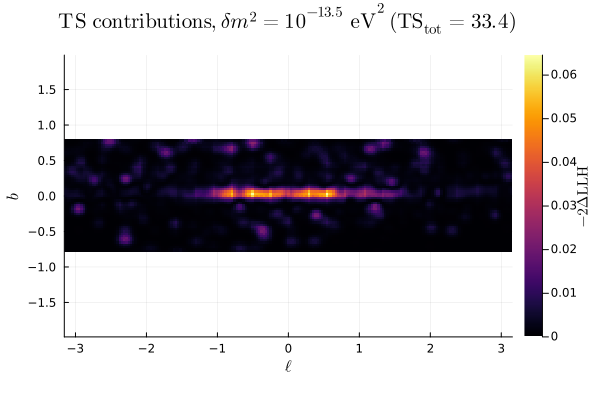

In [74]:
heatmap(
    range(-π, π, 199),
    range(-π/4, π/4, 51),
    tscontributions, 
    aspect_ratio = 1,
    xlabel=L"\ell",
    ylabel=L"b",
    colorbar_title=L"-2\Delta\mathrm{LLH}",
    title=L"\mathrm{TS~contributions, }\delta m^2 = 10^{-13.5}~\mathrm{eV}^2~\mathrm{(TS_{tot}} = 33.4)"
)